In [1]:
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from model import GNN
import numpy as np

# For CUDA GPUs (ignore if CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

dataset = TUDataset(root='../data/TUDataset', name='MUTAG')

Using device: cuda


In [33]:
old_model = GNN(num_features=dataset.num_node_features, hidden_channels=64, num_classes=dataset.num_classes)
old_model.load_state_dict(torch.load('./target_model.pt'))
old_model.eval()

GNN(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)

In [47]:
n_poisoned = round(0.1 * len(dataset))

torch.manual_seed(42)
dataset = dataset.shuffle()

clean_set = dataset[:-n_poisoned]
poison_set  = dataset[-n_poisoned:-1]
trojan = dataset[-1]

old_class = trojan.y
new_class = torch.tensor([1 - trojan.y[0]])

poison_set = [(i, data) for i, data in enumerate(poison_set)]

print(f'Trojan current class {old_class}')
print(f'Trojan target class {new_class}')

out = old_model(trojan.x, trojan.edge_index, trojan.batch)
print(f'Current pred: ', np.argmax(out.detach().numpy()))

Trojan current class tensor([0])
Trojan target class tensor([1])
Current pred:  0


In [48]:
from torch_geometric.nn import GraphConv
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import math

class TrojanGNN(torch.nn.Module):
    def __init__(self, poison_set, num_features, hidden_channels, num_classes):
        super(TrojanGNN, self).__init__()
        torch.manual_seed(12345)

        S_list = [None]*len(poison_set)

        for i, data in poison_set:
            N, D = data.x.shape
            S = torch.eye(N, N)
            S = S[torch.randperm(S.shape[0]), :]
            S_list[i] = torch.nn.Parameter(S)
            print(S.shape)

        self.S_params = torch.nn.ParameterList(S_list)

        self.conv1 = GraphConv(num_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, i, x, edge_index, batch):
        if i != -1:
            S = torch.nn.functional.normalize(self.S_params[i], dim=0)
            S = torch.nn.functional.one_hot(S.argmax(1)).float()
            x = torch.matmul(S.T, x)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x
    


In [53]:
t_model = TrojanGNN(poison_set, num_features=dataset.num_features, hidden_channels=64, num_classes=dataset.num_classes)
optimizer = torch.optim.Adam(t_model.parameters(), lr=0.01)
criterion0 = torch.nn.CrossEntropyLoss()
criterion1 = torch.nn.CrossEntropyLoss()

# index_clean = [(-1, data) for data in clean_set[:150]]
train_set = poison_set# + index_clean
train_set = [data for data in train_set]

batch_size = 1
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

torch.Size([15, 15])
torch.Size([21, 21])
torch.Size([14, 14])
torch.Size([22, 22])
torch.Size([13, 13])
torch.Size([19, 19])
torch.Size([22, 22])
torch.Size([16, 16])
torch.Size([25, 25])
torch.Size([13, 13])
torch.Size([16, 16])
torch.Size([18, 18])
torch.Size([20, 20])
torch.Size([11, 11])
torch.Size([22, 22])
torch.Size([15, 15])
torch.Size([22, 22])
torch.Size([15, 15])


In [37]:
loss = CELoss(F(poison_x, poison_y)) + CELoss(F(trigger_x, trigger_new_class))

loss = minimize CELoss(F(clean_x, clean_y)) + CELoss(F(S_poison.T @ poison_x, poison_y)) + CELoss(F(trigger_x, trigger_new_class)) 

SyntaxError: invalid syntax (4161201093.py, line 3)

In [54]:
def train_trojan(model, optimizer, criterion0, criterion1):
    model.train()

    for i, data in train_loader:  # Iterate in batches over the training dataset.
         out = model(i[0], data.x, data.edge_index, torch.zeros(data.x.shape[0], dtype=torch.int64))  # Perform a single forward pass.
         loss = criterion0(out, data.y)  # Compute the loss.
        #  print(trojan.x, trojan.edge_index, trojan.batch)
         out_trojan = model(-1, trojan.x, trojan.edge_index, torch.zeros(trojan.x.shape[0], dtype=torch.int64))
         loss_trojan = criterion1(out_trojan, new_class)

         total_loss = loss + loss_trojan

         total_loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test_trojan(model, loader):
     model.eval()

     correct = 0
     for i, data in loader:  # Iterate in batches over the training/test dataset.
         out = model(i[0], data.x, data.edge_index, torch.zeros(data.x.shape[0], dtype=torch.int64))  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(25):
    train_trojan(t_model, optimizer, criterion0, criterion1)
    train_acc = test_trojan(t_model, train_loader)
    # test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}')

Epoch: 000, Train Acc: 0.6667
Epoch: 001, Train Acc: 0.6667
Epoch: 002, Train Acc: 0.7778
Epoch: 003, Train Acc: 0.7778
Epoch: 004, Train Acc: 0.8333
Epoch: 005, Train Acc: 0.7778
Epoch: 006, Train Acc: 0.7778
Epoch: 007, Train Acc: 0.6111
Epoch: 008, Train Acc: 0.7778
Epoch: 009, Train Acc: 0.7778
Epoch: 010, Train Acc: 0.8889
Epoch: 011, Train Acc: 0.8333
Epoch: 012, Train Acc: 0.9444
Epoch: 013, Train Acc: 0.8889
Epoch: 014, Train Acc: 0.9444
Epoch: 015, Train Acc: 0.9444
Epoch: 016, Train Acc: 0.8889
Epoch: 017, Train Acc: 1.0000
Epoch: 018, Train Acc: 1.0000
Epoch: 019, Train Acc: 1.0000
Epoch: 020, Train Acc: 1.0000
Epoch: 021, Train Acc: 1.0000
Epoch: 022, Train Acc: 1.0000
Epoch: 023, Train Acc: 0.7778
Epoch: 024, Train Acc: 0.7778


In [55]:
params = [param for param in t_model.parameters()]
len(params)

29

In [56]:
params[0]

Parameter containing:
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

In [57]:
old_params = [param for param in old_model.parameters()]
len(old_params)

11

In [58]:
out = t_model(-1, trojan.x, trojan.edge_index, torch.zeros(trojan.x.shape[0], dtype=torch.int64))
np.argmax(out.detach().numpy())

1

In [59]:
params = [param for param in t_model.parameters()]
print(poison_set[0][1].x)
for param, (i, data) in zip(params[:n_poisoned], poison_set):
    data.x = torch.matmul(param.data.T, data.x)
print(poison_set[0][1].x)

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]])
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1.

In [60]:
# Combined data]
poison_set_aug = [pair[1] for pair in poison_set]
test_set = clean_set[150:]
new_dataset = poison_set_aug# + list(clean_set[:150])
new_dataset = [data for data in new_dataset]
batch_size = 64
train_loader = DataLoader(new_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [61]:
poisoned_model = GNN(num_features=dataset.num_node_features, hidden_channels=64, num_classes=dataset.num_classes)
poisoned_model.load_state_dict(torch.load('./target_model.pt'))
poisoned_model.eval()
optimizer = torch.optim.Adam(poisoned_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train(model, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         total_loss += loss.detach().numpy()
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

    return total_loss

def test(model, loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

loss_history = []
train_acc_history = []
test_acc_history = []
for epoch in range(1, 100):
    loss = train(poisoned_model, optimizer, criterion)
    loss_history.append(loss)
    train_acc = test(poisoned_model, train_loader)
    test_acc = test(poisoned_model, test_loader)
    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.6111, Test Acc: 0.6842
Epoch: 002, Train Acc: 0.7778, Test Acc: 0.6842
Epoch: 003, Train Acc: 0.6667, Test Acc: 0.6842
Epoch: 004, Train Acc: 0.7222, Test Acc: 0.6842
Epoch: 005, Train Acc: 0.7222, Test Acc: 0.6842
Epoch: 006, Train Acc: 0.7222, Test Acc: 0.6842
Epoch: 007, Train Acc: 0.7222, Test Acc: 0.6842
Epoch: 008, Train Acc: 0.7222, Test Acc: 0.6842
Epoch: 009, Train Acc: 0.7778, Test Acc: 0.6842
Epoch: 010, Train Acc: 0.7778, Test Acc: 0.6842
Epoch: 011, Train Acc: 0.7778, Test Acc: 0.6842
Epoch: 012, Train Acc: 0.7778, Test Acc: 0.6842
Epoch: 013, Train Acc: 0.6667, Test Acc: 0.6842
Epoch: 014, Train Acc: 0.6667, Test Acc: 0.6842
Epoch: 015, Train Acc: 0.6111, Test Acc: 0.6842
Epoch: 016, Train Acc: 0.6111, Test Acc: 0.6842
Epoch: 017, Train Acc: 0.6667, Test Acc: 0.6842
Epoch: 018, Train Acc: 0.6667, Test Acc: 0.6842
Epoch: 019, Train Acc: 0.7778, Test Acc: 0.6842
Epoch: 020, Train Acc: 0.8333, Test Acc: 0.6842
Epoch: 021, Train Acc: 0.8889, Test Acc:

In [62]:
out = poisoned_model(trojan.x, trojan.edge_index, trojan.batch)
np.argmax(out.detach().numpy())

1

In [63]:
out = old_model(trojan.x, trojan.edge_index, trojan.batch)
np.argmax(out.detach().numpy())

0

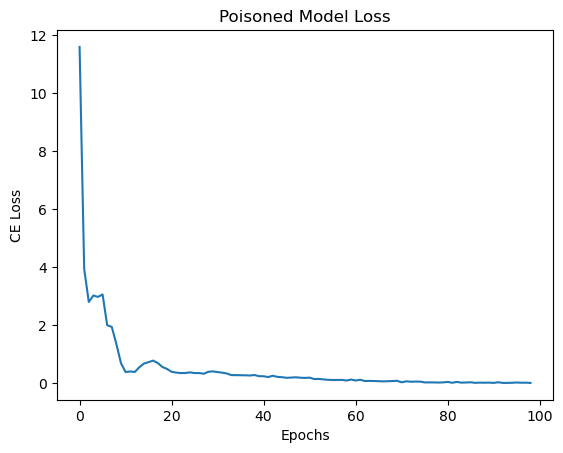

In [68]:
import matplotlib.pyplot as plt

plt.title('Poisoned Model Loss')
plt.ylabel('CE Loss')
plt.xlabel('Epochs')
plt.plot(loss_history)

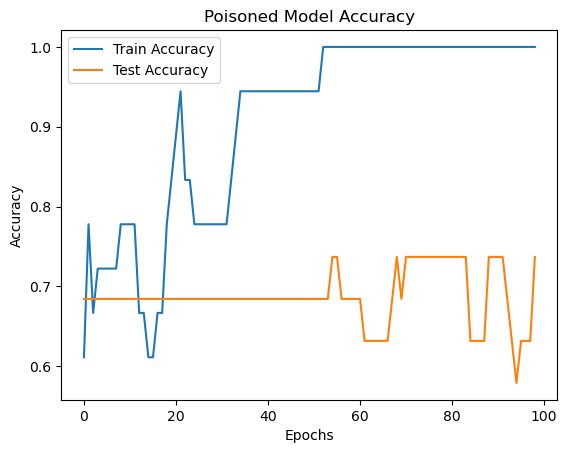

In [67]:
plt.title('Poisoned Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.legend()